# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть».

**Цель:** решить, где бурить новую скважину.

**Задачи:** построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

**Описание данных:**

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Признаки в датасетах:

- `id` — уникальный идентификатор скважины
- `f0, f1, f2` — три признака точек
- `product` — объём запасов в скважине (тыс. баррелей)

**Шаги для выбора локации:**

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

RANDOM_STATE = np.random.RandomState(12345)

## Загрузка и подготовка данных

### Загрузка данных

In [2]:
gd_0 = pd.read_csv('C:/FATHER/datasets/geo_data_0.csv')
gd_1 = pd.read_csv('C:/FATHER/datasets/geo_data_1.csv')
gd_2 = pd.read_csv('C:/FATHER/datasets/geo_data_2.csv')

In [3]:
def description(df):
    display(df.head())
    df.info()

In [4]:
description(gd_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
description(gd_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
description(gd_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


### Предобработка данных

Запишем значения `id` в индексы.

In [7]:
gd_0 = gd_0.set_index('id')
gd_1 = gd_1.set_index('id')
gd_2 = gd_2.set_index('id')

В данных нет пропусков, все значения представленны в нужном типе данных. Проверим на наличие дубликатов.

In [8]:
gd_0.duplicated(subset=['f0','f1','f2']).sum()

0

In [9]:
gd_1.duplicated(subset=['f0','f1','f2']).sum()

0

In [10]:
gd_2.duplicated(subset=['f0','f1','f2']).sum()

0

### Исследовательский анализ

Посмотрим, как распределены признаки в датасетах.

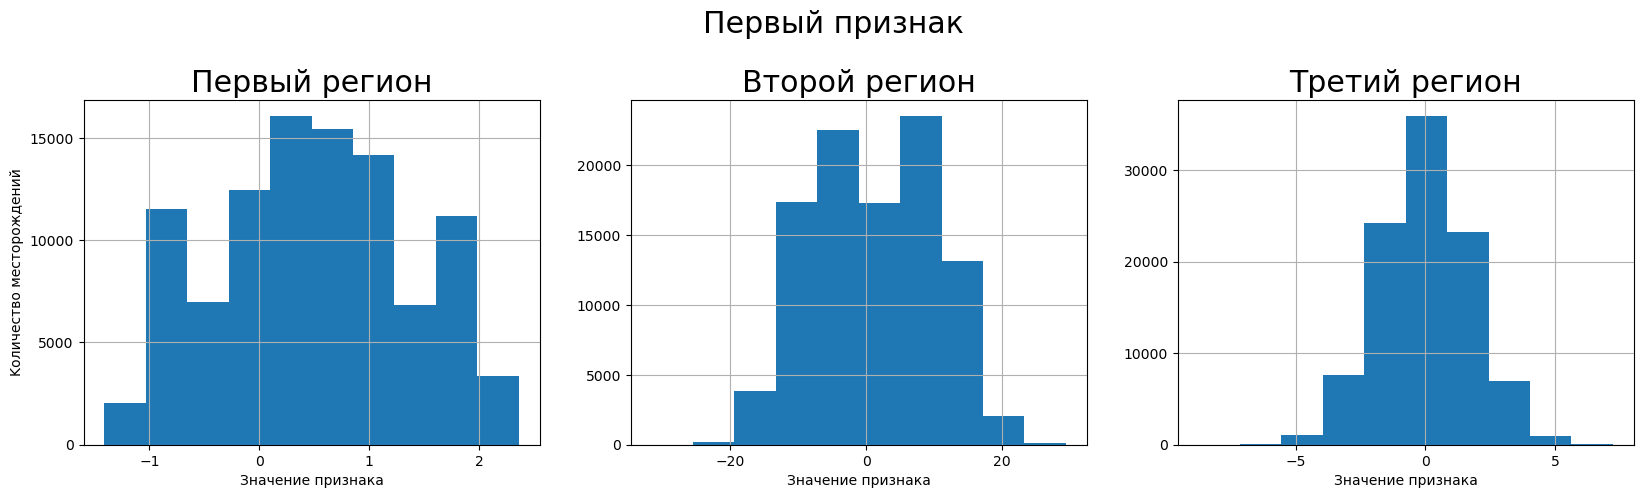

In [11]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '18'

gd_0['f0'].hist(bins=10,ax=axs[0])
axs[0].set_title('Первый регион')
axs[0].set_ylabel('Kоличество месторождений')
axs[0].set_xlabel('Значение признака')

gd_1['f0'].hist(ax=axs[1])
axs[1].set_title('Второй регион')
axs[1].set_xlabel('Значение признака')

gd_2['f0'].hist(ax=axs[2])
axs[2].set_title('Третий регион')
axs[2].set_xlabel('Значение признака')

fig.suptitle('Первый признак')
plt.subplots_adjust(top= 0.8)
plt.show()

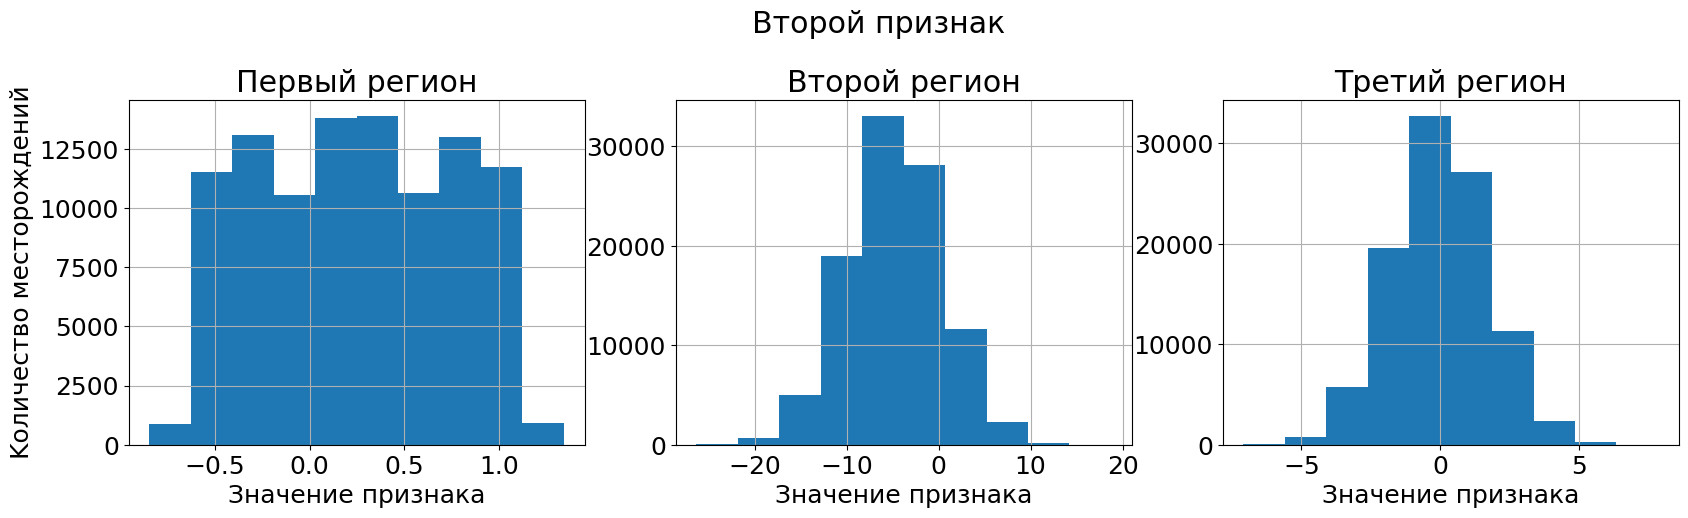

In [12]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '18'

gd_0['f1'].hist(bins=10,ax=axs[0])
axs[0].set_title('Первый регион')
axs[0].set_ylabel('Kоличество месторождений')
axs[0].set_xlabel('Значение признака')

gd_1['f1'].hist(ax=axs[1])
axs[1].set_title('Второй регион')
axs[1].set_xlabel('Значение признака')

gd_2['f1'].hist(ax=axs[2])
axs[2].set_title('Третий регион')
axs[2].set_xlabel('Значение признака')

fig.suptitle('Второй признак')
plt.subplots_adjust(top= 0.8)
plt.show()

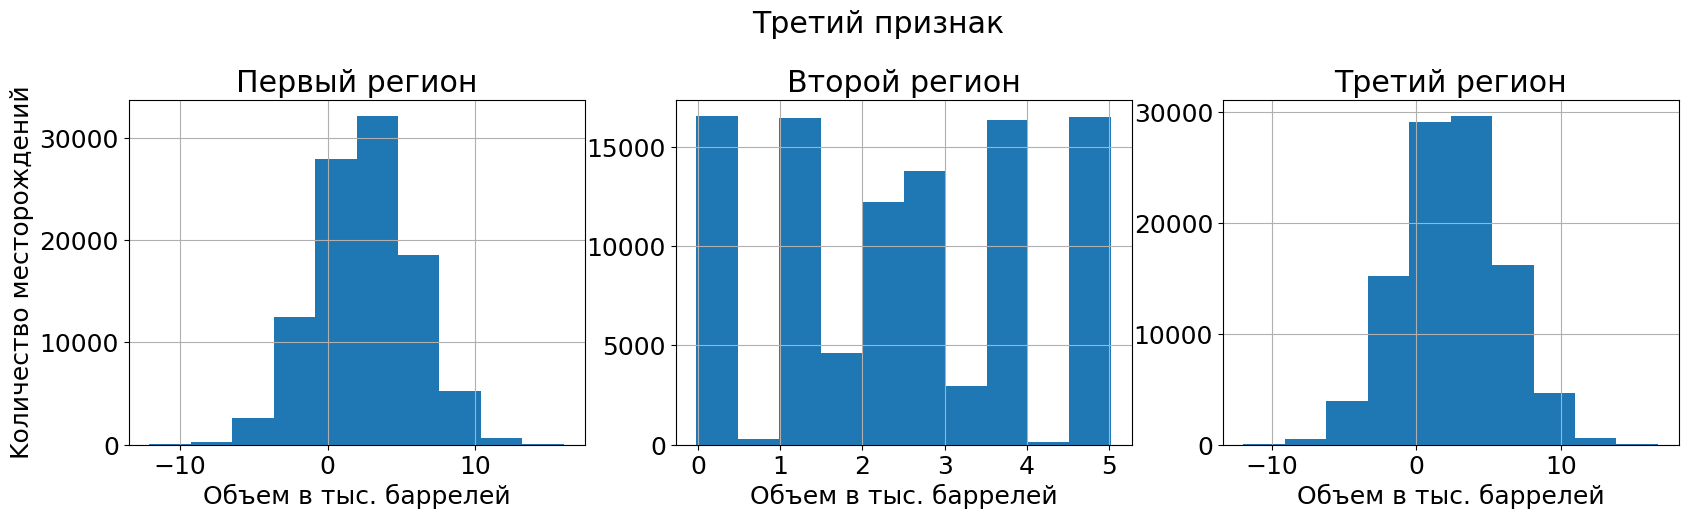

In [13]:
fig, axs = plt.subplots(nrows= 1 , ncols= 3 )
fig.set_size_inches(20, 5)
plt.rcParams['font.size'] = '18'

gd_0['f2'].hist(bins=10,ax=axs[0])
axs[0].set_title('Первый регион')
axs[0].set_ylabel('Kоличество месторождений')
axs[0].set_xlabel('Объем в тыс. баррелей')

gd_1['f2'].hist(ax=axs[1])
axs[1].set_title('Второй регион')
axs[1].set_xlabel('Объем в тыс. баррелей')

gd_2['f2'].hist(ax=axs[2])
axs[2].set_title('Третий регион')
axs[2].set_xlabel('Объем в тыс. баррелей')

fig.suptitle('Третий признак')
plt.subplots_adjust(top= 0.8)
plt.show()

Признаки в датасетах имеют разные диапазоны значений, но все значения симметричны относительно своего среднего.

Посмотрим на распределение `product`.

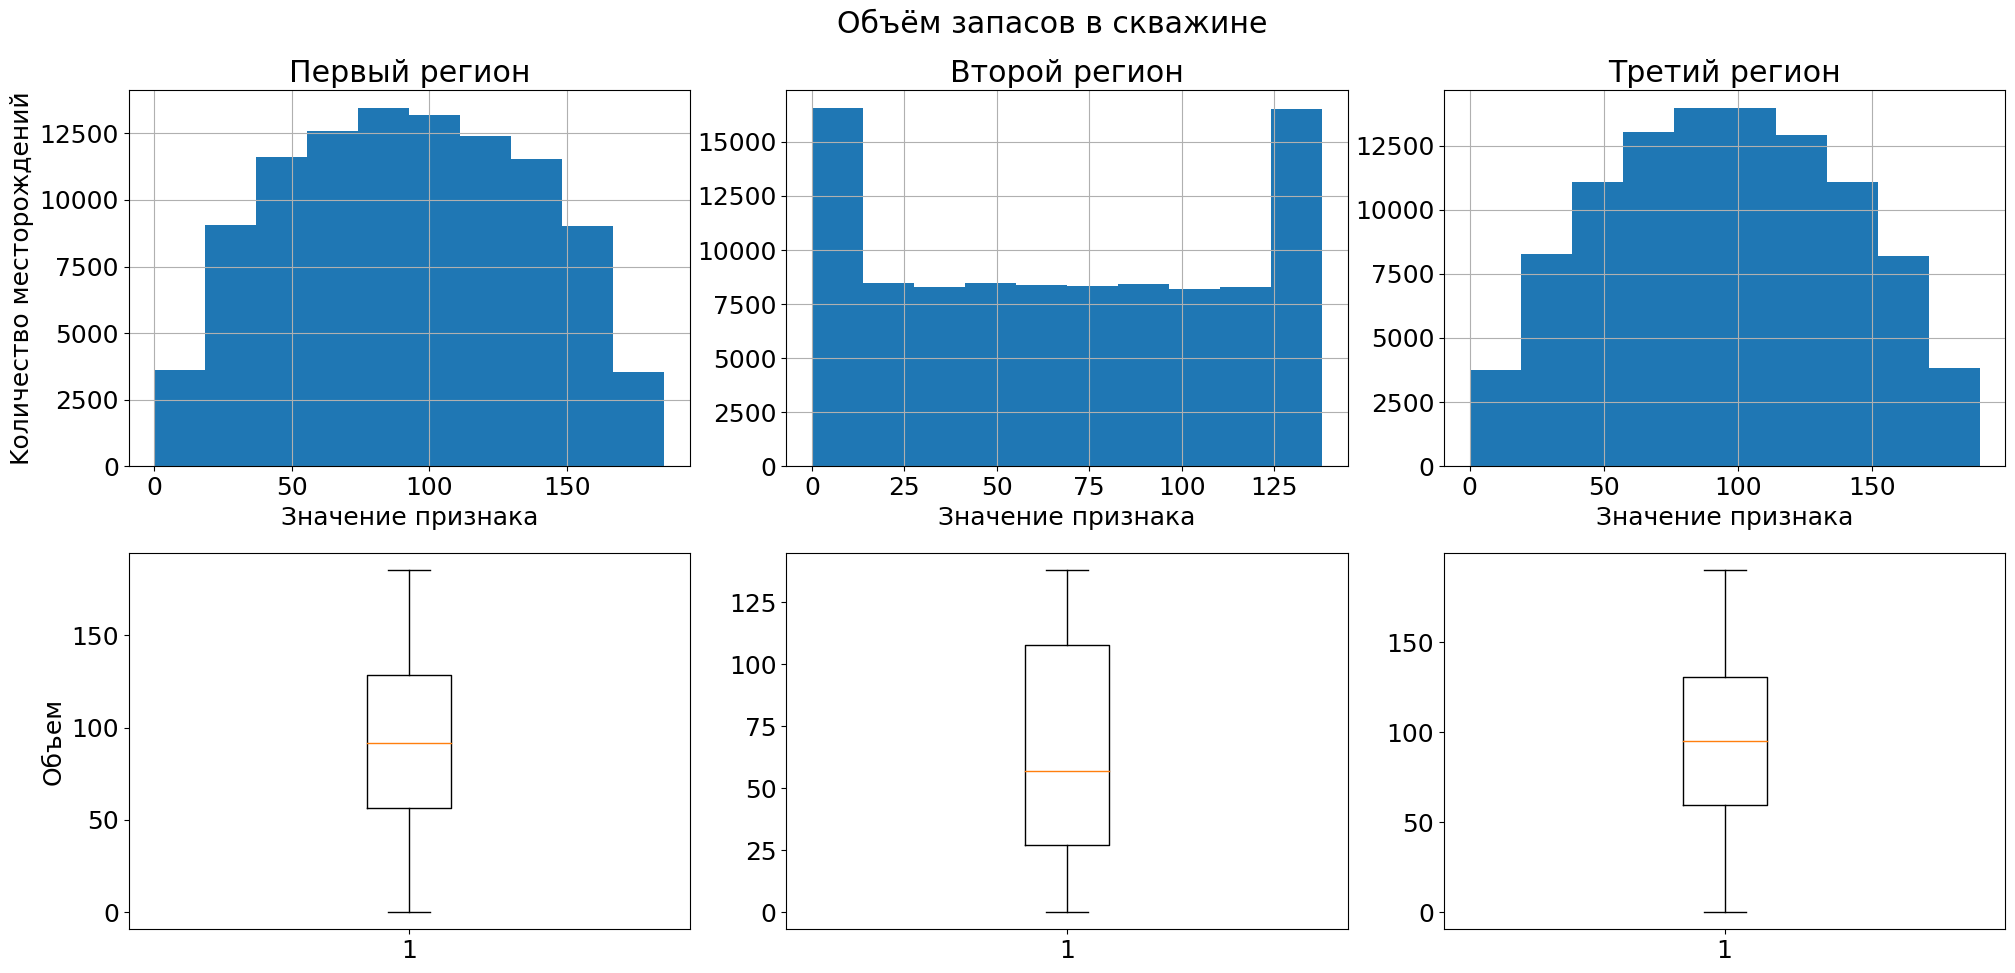

In [14]:
fig, axs = plt.subplots(nrows= 2 , ncols= 3 )
fig.set_size_inches(20, 10)
plt.rcParams['font.size'] = '18'
fig. tight_layout(h_pad= 2)

gd_0['product'].hist(bins=10,ax=axs[0][0])
axs[0][0].set_title('Первый регион')
axs[0][0].set_ylabel('Kоличество месторождений')
axs[0][0].set_xlabel('Значение признака')

gd_1['product'].hist(ax=axs[0][1])
axs[0][1].set_title('Второй регион')
axs[0][1].set_xlabel('Значение признака')

gd_2['product'].hist(ax=axs[0][2])
axs[0][2].set_title('Третий регион')
axs[0][2].set_xlabel('Значение признака')

axs[1][0].boxplot(x = gd_0['product'])
axs[1][0].set_ylabel('Объем')

axs[1][1].boxplot(x = gd_1['product'])

axs[1][2].boxplot(x = gd_2['product'])

fig.suptitle('Объём запасов в скважине')
plt.subplots_adjust(top= 0.9)
plt.show()

### Корреляционный анализ

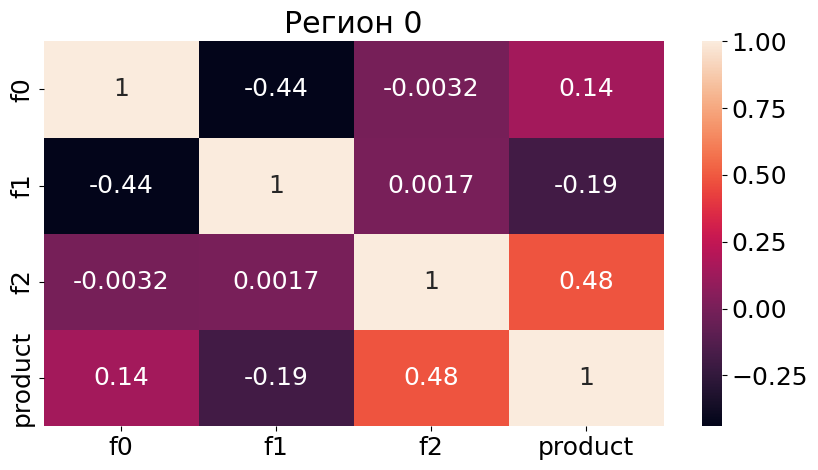

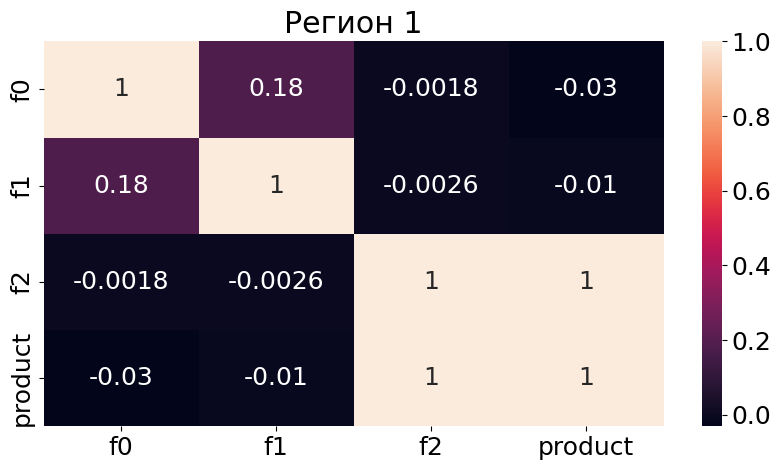

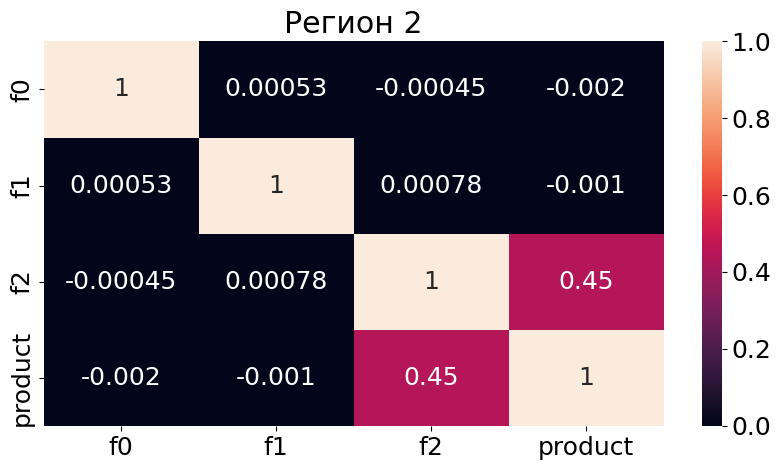

In [15]:
gd = [gd_0,gd_1,gd_2]
for i in range(3):
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 1, 1) 
    plt.title('Регион ' + str(i))
    sns.heatmap(gd[i].corr(), annot = True);


### Вывод

Мы загрузили три датасета. В данных нет пропусков и дубликатов. Почти все признаки распределены симметрично относительно своего среднего. Во всех регионах больше всего с целевым признаком коррелирует `f2`.

## Обучение и проверка модели

Обучим три модели линейной регрессии и предскажем объемы добываемого сырья.

In [16]:
y_tests = []
y_preds = []

In [17]:
def pred_reg(df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['product'], axis=1),
                                                        df['product'],
                                                        test_size=0.25,
                                                        random_state = RANDOM_STATE)

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_preds.append(pd.Series(y_pred))
    y_tests.append(pd.Series(y_test).reset_index(drop= True ))

In [18]:
data = pd.DataFrame(columns=['Регион','Средний запас сырья','RMSE'])

for df in [gd_0, gd_1, gd_2]:
    pred_reg(df)
for i in range(3):
    data.loc[ len(data.index )] = ['Регион '+str(i), y_preds[i].mean(),
                                   mean_squared_error(y_tests[i], y_preds[i], squared=False)]


In [19]:
data

,Регион,Средний запас сырья,RMSE
0,Регион 0,92.592568,37.579422
1,Регион 1,68.769951,0.889737
2,Регион 2,95.087528,39.958042


**Вывод:**

Средний запас сырья в первом и третьем регионах примерно одинаковый, чуть больше 90 тыс. баррелей. Однако модели на этих друг регионах сильно ошибаются, среднеквадратичная ошибка равна примерно 40. Во втором регионе средний запас сырья меньше, чем в других (69 тыс. баррелей), но модель почти не ошибается (rmse = 0.89).

## Подготовка к расчёту прибыли

Для разработки выбираются 200 лучших точек. На разработку скважин в регионе отводится 10 млрд рублей. Один баррель сырья приносит 450 рублей дохода. Рассчитаем достаточных объем сырья для безубыточной разработки новой скважины.

In [20]:
COUNT = 200
MONEY = 10**10
REVENUE = 45*(10**4)

In [21]:
a = MONEY/(COUNT*REVENUE)
print('Достаточный объём для безубыточной разработки новой скважины:', round(a))

Достаточный объём для безубыточной разработки новой скважины: 111


**Вывод:**

Средний запас сырья в трех регионах меньше, чем достаточный объем для безубыточной разработки.

## Расчёт прибыли и рисков 

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

In [22]:
def profit(pred, true):
    pred = pred.sort_values(ascending=False)
    selected = true[pred.index][:COUNT]
    return REVENUE * selected.sum() - MONEY

Посчитаем риски и прибыль для каждого региона.

In [23]:
def risk(pred,true):
    values = []
    for i in range(1000):
        pred_sample = pred.sample(n=500, replace=True, random_state = RANDOM_STATE)
        true_sample = true[pred_sample.index]
        
        values.append(profit(pred_sample, true_sample))
    
    values = pd.Series(values)
    mean = values.mean() / 10**6
    q_1 = values.quantile(0.025) / 10**6
    q_2 = values.quantile(0.975) /10**6
    r = values[values<0].count() / values.count() * 100
    print('Средняя прибыль: ', round(mean), 'млн руб.')
    print('95% доверительный интервал: от ', round(q_1), 'млн руб. до', round(q_2),' млн руб.')
    print('Риск убытков равен ', r, '%')

In [24]:
print('Первый регион')
risk(y_preds[0], y_tests[0])

Первый регион
Средняя прибыль:  424 млн руб.
95% доверительный интервал: от  -76 млн руб. до 958  млн руб.
Риск убытков равен  4.8 %


In [25]:
print('Второй регион')
risk(y_preds[1], y_tests[1])

Второй регион
Средняя прибыль:  513 млн руб.
95% доверительный интервал: от  108 млн руб. до 929  млн руб.
Риск убытков равен  0.6 %


In [26]:
print('Третий регион')
risk(y_preds[2], y_tests[2])

Третий регион
Средняя прибыль:  381 млн руб.
95% доверительный интервал: от  -143 млн руб. до 893  млн руб.
Риск убытков равен  7.3999999999999995 %


**Вывод:**

Минимальный риск убытков во втором регионе. Только там 95% доверительный интерал не отрицательный. Также во втором регионе наибольшая средняя прибыль.

## Вывод

Мы построили модель, которая предсказывает объем добываемого сырья в скважинах, посчитали прибыль и риски в регионах. 

Мы построили три модели для разных регионов. Меньше всего ошибается вторая модель (rmse = 0.9), значит ее предсказаниям можно доверять. 

С помощью техники Bootstrap мы рассчитали среднюю прибыль, 95% доверительный интервал и риск убытков в каждом регионе. По всем параметрам "выигрывает" второй регион. Он имеет большую среднюю прибыль, его доверительный интервал не уходит в отрицательные значения и риск убытков очень мал (0.5%). 

После всей проделанной работы к разработке скважин рекомендуется втрой регион.